# Análisis de CLAP Scores: Sin Reprompt vs Con Reprompt

Este análisis evalúa el impacto del reprompting en la calidad de alineación texto-audio usando como métrica CLAP scores.

**Data**: 50 pares de evaluaciones en tres condiciones:
- Sin Reprompt: texto original + audio original
- Cross-Evaluation: texto original + audio reprompt  
- Con Reprompt: texto reprompt + audio reprompt


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from config import PROJECT_ROOT, load_config, setup_project_paths

setup_project_paths()
config = load_config()

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

CLAP_SCORES_PATH = PROJECT_ROOT / config.data.data_clap_path


df_prompt = pd.read_csv(str(CLAP_SCORES_PATH / 'clap_score_results_prompt_outputs.csv'))
df_reprompt = pd.read_csv(str(CLAP_SCORES_PATH / 'clap_score_results_reprompt_outputs.csv'))
df_cross = pd.read_csv(str(CLAP_SCORES_PATH / 'clap_score_results_prompt_outputs_cross_evaluation.csv'))


comparison_df = df_prompt[['id_prompt', 'text', 'clap_score']].merge(
    df_cross[['id_prompt', 'clap_score']], 
    on='id_prompt', 
    suffixes=('_sin_reprompt', '_cross_eval')
).merge(
    df_reprompt[['id_prompt', 'clap_score']], 
    on='id_prompt'
).rename(columns={'clap_score': 'clap_score_con_reprompt'})

comparison_df['diferencia_reprompt'] = (
    comparison_df['clap_score_con_reprompt'] - comparison_df['clap_score_sin_reprompt']
)

## 1. Estadísticas Descriptivas

Resumen de CLAP scores por condición:

In [2]:
summary_stats = pd.DataFrame({
    'Sin Reprompt': comparison_df['clap_score_sin_reprompt'].describe(),
    'Cross Eval': comparison_df['clap_score_cross_eval'].describe(),
    'Con Reprompt': comparison_df['clap_score_con_reprompt'].describe()
}).round(4)

summary_stats

,Sin Reprompt,Cross Eval,Con Reprompt
count,50.0000,50.0000,50.0000
mean,0.1191,0.1247,0.1787
std,0.1125,0.1020,0.2013
min,-0.1171,-0.1457,-0.2576
25%,0.0629,0.0586,0.0386
50%,0.1207,0.1242,0.1816
75%,0.1947,0.1919,0.3364
max,0.3984,0.3405,0.6152


## 2. Comparación Visual de Distribuciones

/var/folders/p3/7n0xc16x2cz3psh_2bhr4m8w0000gn/T/ipykernel_83207/724714885.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(data_to_plot, labels=labels, patch_artist=True, showmeans=True,


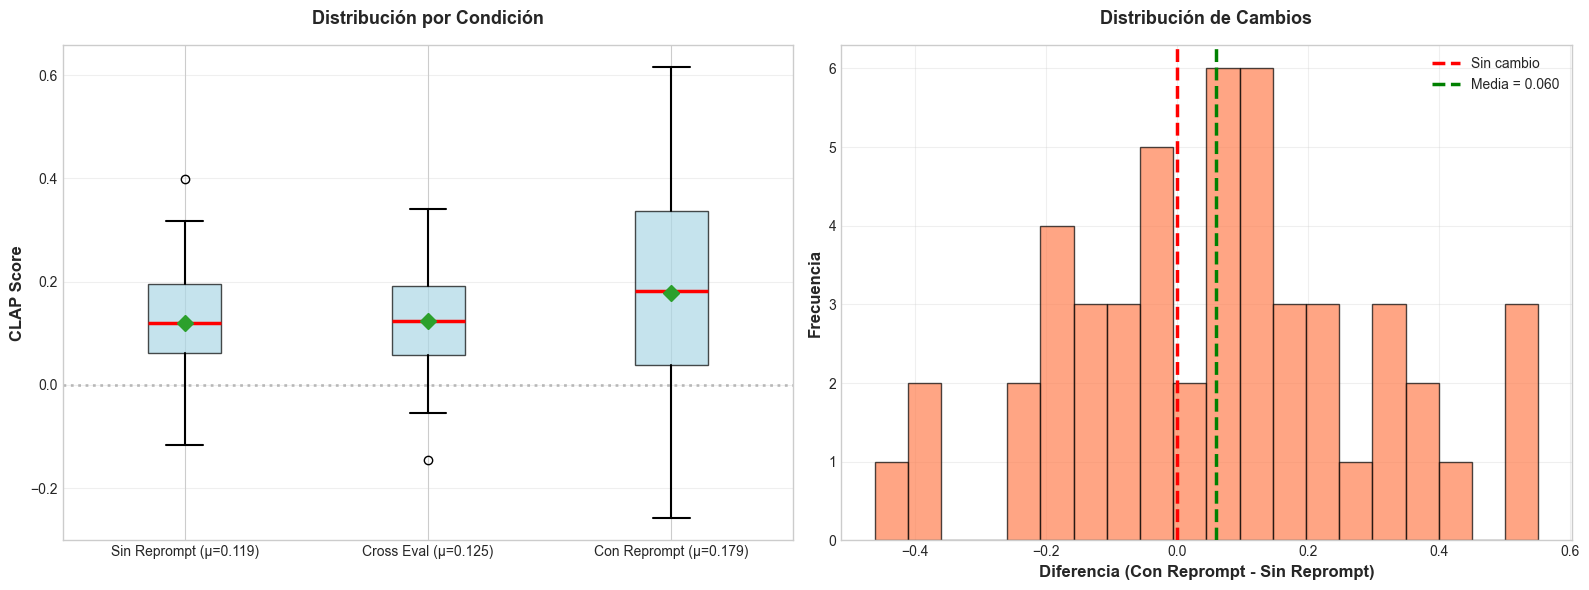

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plots
data_to_plot = [
    comparison_df['clap_score_sin_reprompt'],
    comparison_df['clap_score_cross_eval'],
    comparison_df['clap_score_con_reprompt']
]
labels = ['Sin Reprompt (μ=0.119)', 'Cross Eval (μ=0.125)', 'Con Reprompt (μ=0.179)']

bp = axes[0].boxplot(data_to_plot, labels=labels, patch_artist=True, showmeans=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2.5),
                     meanprops=dict(color='green', linewidth=2.5, linestyle='--',
                                   marker='D', markersize=8),
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5))

axes[0].axhline(y=0, color='gray', linestyle=':', linewidth=2, alpha=0.5)
axes[0].set_ylabel('CLAP Score', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución por Condición', fontsize=13, fontweight='bold', pad=15)
axes[0].grid(True, alpha=0.3, axis='y')

# Histograma de diferencias
axes[1].hist(comparison_df['diferencia_reprompt'], bins=20, 
             edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2.5, 
                label='Sin cambio', zorder=5)
axes[1].axvline(comparison_df['diferencia_reprompt'].mean(), 
                color='green', linestyle='--', linewidth=2.5,
                label=f"Media = {comparison_df['diferencia_reprompt'].mean():.3f}", zorder=5)
axes[1].set_xlabel('Diferencia (Con Reprompt - Sin Reprompt)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[1].set_title('Distribución de Cambios', fontsize=13, fontweight='bold', pad=15)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Top 5 mayores diferencias Prompt - Reprompt

In [4]:
comparison_df.sort_values(by='diferencia_reprompt', ascending=False).head(5)

,id_prompt,text,clap_score_sin_reprompt,clap_score_cross_eval,clap_score_con_reprompt,diferencia_reprompt
13,14,We're at the farmers market and we're gonna ea...,-0.025266,-0.054174,0.526347,0.551612
9,10,I'm at the bakery and I'm gonna eat a chocolat...,0.074484,0.022280,0.615249,0.540764
21,22,I'm gonna drink a cup of chamomile tea in the ...,-0.081863,0.113309,0.430991,0.512854
29,30,I'm gonna drink a bottle of coconut water in t...,0.040642,0.062498,0.470121,0.429478
4,5,We're at the stadium and we're gonna eat a chi...,-0.005556,0.192167,0.392140,0.397696


### Top 5 peores diferencias Prompt - Reprompt

In [5]:
comparison_df.sort_values(by='diferencia_reprompt', ascending=True).head(5)

,id_prompt,text,clap_score_sin_reprompt,clap_score_cross_eval,clap_score_con_reprompt,diferencia_reprompt
10,11,We're on the rooftop terrace and we're gonna d...,0.204907,0.154532,-0.257557,-0.462464
47,48,I feel curious and I'm gonna drink a turmeric ...,0.257814,0.191005,-0.151392,-0.409206
8,9,I'm in the gym and I'm gonna drink a vanilla p...,0.156999,0.226840,-0.223609,-0.380608
17,18,I'm gonna drink a flat white in the cafe. The ...,0.214594,0.295807,-0.017294,-0.231888
2,3,We're at the beach and we're gonna eat two fis...,0.093535,0.052864,-0.131710,-0.225245


## 3. Validación de Independencia

**Pregunta**: ¿Son los CLAP scores independientes del audio específico utilizado?

Usamos prompt - audio prompt vs reprompt - audio reprompt

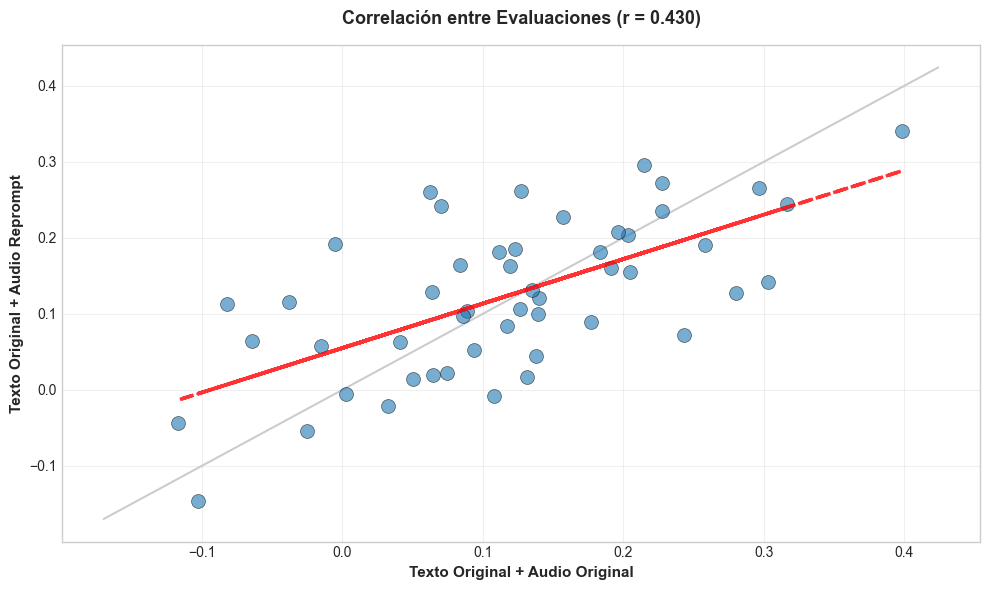

In [6]:
correlation = comparison_df['clap_score_sin_reprompt'].corr(
    comparison_df['clap_score_cross_eval'], method="kendall"
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(comparison_df['clap_score_sin_reprompt'], 
           comparison_df['clap_score_cross_eval'],
           alpha=0.6, s=100, edgecolors='black', linewidth=0.5)

z = np.polyfit(comparison_df['clap_score_sin_reprompt'], 
               comparison_df['clap_score_cross_eval'], 1)
p = np.poly1d(z)
ax.plot(comparison_df['clap_score_sin_reprompt'], 
        p(comparison_df['clap_score_sin_reprompt']), 
        "r--", alpha=0.8, linewidth=2.5)

lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k-', alpha=0.2, zorder=0)

ax.set_xlabel('Texto Original + Audio Original', fontsize=11, fontweight='bold')
ax.set_ylabel('Texto Original + Audio Reprompt', fontsize=11, fontweight='bold')
ax.set_title(f'Correlación entre Evaluaciones (r = {correlation:.3f})', 
             fontsize=13, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Hallazgo**: Correlación moderada (r = 0.43) indica que los scores **NO son completamente independientes** del audio usado.

## 4. ¿Hay Diferencia Significativa?

Comparación mediante prueba estadistica T entre Sin Reprompt vs Con Reprompt:

In [7]:
t_stat, p_value = stats.ttest_rel(
    comparison_df['clap_score_sin_reprompt'],
    comparison_df['clap_score_con_reprompt']
)

mean_sin = comparison_df['clap_score_sin_reprompt'].mean()
mean_con = comparison_df['clap_score_con_reprompt'].mean()
mean_diff = mean_con - mean_sin

p_std = np.sqrt(
    (comparison_df['clap_score_sin_reprompt'].std()**2 + 
     comparison_df['clap_score_con_reprompt'].std()**2) / 2
)
cohens_d = mean_diff / p_std

results_df = pd.DataFrame({
    'Métrica': ['Media Sin Reprompt', 'Media Con Reprompt', 'Diferencia', 
                'Cambio %', 'Estadístico t', 'Valor p', "Cohen's d"],
    'Valor': [f'{mean_sin:.4f}', f'{mean_con:.4f}', f'{mean_diff:.4f}',
              f'{(mean_diff/mean_sin)*100:+.1f}%', f'{t_stat:.4f}', 
              f'{p_value:.4f}', f'{cohens_d:.4f}']
})

results_df

,Métrica,Valor
0,Media Sin Reprompt,0.1191
1,Media Con Reprompt,0.1787
2,Diferencia,0.0595
3,Cambio %,+50.0%
4,Estadístico t,-1.7876
5,Valor p,0.0800
6,Cohen's d,0.3652


**Hallazgo**: No hay diferencia estadísticamente significativa (p = 0.08 > 0.05), el tamaño del efecto es pequeño-moderado (d = 0.37).

Existe una tendencia hacia mejores scores con reprompt (~50% de incremento promedio).

## 5. Conclusiones Principales

### Hallazgos Clave

**1. Independencia Limitada**
- Correlación r = 0.43 (Kendall) entre evaluaciones con diferentes audios
- Los scores NO son completamente independientes del audio usado

**2. Tendencia pero No Significancia Estadística**
- Prueba T: t = -1.79, p = 0.08 (> 0.05)
- No significativo al nivel α = 0.05
- Tendencia clara hacia mejora con reprompt (+50% promedio)
- Tamaño de efecto pequeño-moderado (Cohen's d = 0.37)

**3. Alta Variabilidad en Resultados**
- Desviación estándar aumenta: 0.11 → 0.20
- Resultados heterogéneos: algunos mejoran significativamente, otros empeoran
- El beneficio del reprompt depende del prompt específico

**4. Distribución de Cambios**
- Mayoria de prompts mejoran con reprompt
- Variabilidad alta indica que no es beneficioso universalmente
- Es necesario análisis cualitativo para identificar patrones

### Limitaciones

- Tamaño de muestra moderado (n = 50)
- P-value marginal requiere interpretación cuidadosa
- Alta variabilidad indica factores no controlados en el estudio
- CLAP score como única métrica de evaluación